In [1]:
import os
import torch
import torchvision
# import torchvision.transforms as transforms
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.progress import track
from skimage import io, transform


seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

batch_size = 64
img_size = 180

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Running on GPU: {}.'.format(torch.cuda.get_device_name()))
else:
    print('Running on CPU.')

In [2]:
def load_data_first_time(img_size, desired=None):
    preset_mean = [0.0, 0.0, 0.0]
    preset_std = [0.0, 0.0, 0.0]

    transform = transforms.Compose(
        [
         transforms.Resize(img_size),
         transforms.CenterCrop(img_size),
         transforms.ToTensor()
         ])

    imageDataset = torchvision.datasets.ImageFolder(root='./alldata', transform=transform)
    
    random.shuffle(imageDataset.imgs)


    print ("Sample Images:", imageDataset.imgs[:5])
    print ("Labels:", imageDataset.class_to_idx)

    num_classes = len(imageDataset.classes)

    print ("Number of images:",len(imageDataset))
    
    return imageDataset

imageDataset = load_data_first_time(img_size)
classes = imageDataset.classes


In [4]:
loader = torch.utils.data.DataLoader(imageDataset,
                         batch_size=32,
                         shuffle=False)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*180*180))

In [5]:
mean, std

(tensor([0.3830, 0.2347, 0.2191], device='cpu'),
 tensor([0.2029, 0.1551, 0.1607], device='cpu'))

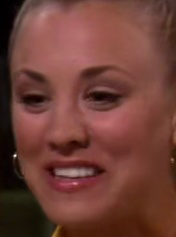

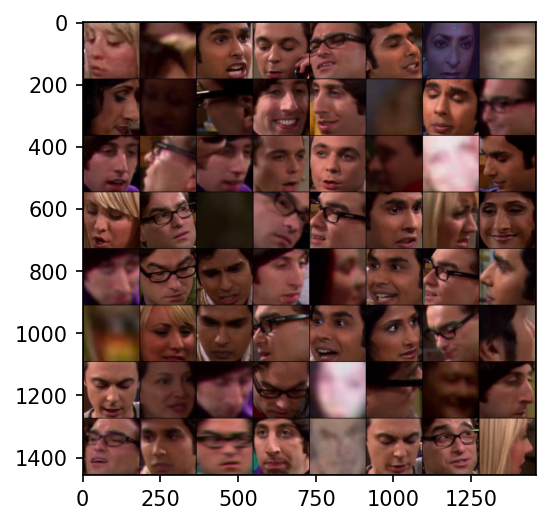

In [4]:
from PIL import Image
im = Image.open('./alldata/Penny/face458_c44b8e1e-2a9e-11eb-aff2-002432182720.jpg')
display(im)

def imshow(img, normalize=True):
    nimg = img.numpy()
    if normalize:
        nimg[0, :, :] += 0.3831
        nimg[1, :, :] += 0.2346
        nimg[2, :, :] += 0.2189
    
    plt.imshow(np.transpose(nimg, (1, 2, 0)))
    plt.show()


# get some random training images

trainloader = torch.utils.data.DataLoader(imageDataset, batch_size=batch_size,shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), False)
# print labels
# print(' '.join('%5s' % classes[labels[j]][0] for j in range(batch_size)))

In [5]:
def load_fulldata(img_size, desired=None):
    
    means = [0.3831, 0.2346, 0.2189]
    stds =  [0.2026, 0.1548, 0.1604]
    
    transform = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])

    fulldataset = datasets.ImageFolder(root='./alldata', transform = transform)
    random.shuffle(fulldataset.imgs)
    
    if desired:
        for i in range(len(fulldataset)):
            img , label = fulldataset.imgs[i]
            if label == desired:
                fulldataset.imgs[i] = (img, 1)
            else:
                fulldataset.imgs[i] = (img, 0)
    
    print (fulldataset.imgs[:15])
    
    

    return fulldataset




In [6]:

def get_loaders(data):
    n = len(data)
    n_train = int(0.7 * n)
    n_valid = int(0.15 * n)
    n_test  = int(0.15 * n)
    
    random.shuffle(data.imgs)

    train_set = torch.utils.data.Subset(data, range(0, n_train))
    valid_set = torch.utils.data.Subset(data, range(n_train, n_train + n_valid))
    test_set  = torch.utils.data.Subset(data, range(n_train + n_valid, n))
    
    print (batch_size)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=True)
    
    return train_loader, valid_loader, test_loader


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm1 = nn.BatchNorm2d(10)
        self.conv_norm2 = nn.BatchNorm2d(10)
        
        self.conv_norm1.track_running_stats=False
        self.conv_norm2.track_running_stats=False
        

        self.conv1 = nn.Conv2d(3,  10, 3)
        self.conv2 = nn.Conv2d(10, 10, 3)
        
        self.fc1 = nn.Linear(10*43*43, 400)
        self.fc2 = nn.Linear(400, 7)

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm2(self.conv2(x))))
        
        x = x.view(-1,10*43*43)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [8]:
from collections import Counter
def evaluate(model, v, show, loss_fnc, desired=False, sensitivity=False):
    total = 0
    correct = 0
    vloss = 0
    
    ones = torch.ones([batch_size], dtype=torch.long)
    neg_ones = -1 * ones
    twos = ones + 1
    
    TPs = 0.
    FPs = 0.
    FNs = 0.
    
    TP_dict = Counter()
    FN_dict = Counter()
    
    
    
    with torch.no_grad():
        for data in v:
            images, labels = data
            outputs = model(images.type(torch.cuda.FloatTensor))
            labels = labels.type(torch.cuda.LongTensor)

            vloss += loss_fnc(input=outputs.squeeze(), target=labels)


            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            
            
            if sensitivity:
                if desired:
                    for i in range(len(predicted)):
                        if predicted[i] == 1:
                            if predicted[i] == labels[i]:
                                TPs += 1
                            else:
                                FNs += 1
                else:
                    for i in range(len(predicted)):
                        if predicted[i] == labels[i]:
                            TP_dict[classes[labels[i]]] += 1
                        else:
                            FN_dict[classes[labels[i]]] += 1
                    

            lookup = classes

            if desired:
                lookup = ["Extra", classes[desired]]

            
            if show:
                for i in range(len(predicted)):
                    if predicted[i] != labels[i]:
                        imshow(images[i])
                        

                        print (">>>>>>", lookup[predicted[i]])
                        print ("Truth:", lookup[labels[i]])
    
    if sensitivity:
        if desired:
            if TPs == 0:
                return 0, vloss.item()/len(v)
            return TPs/(TPs+FNs), vloss.item()/len(v)
            
        else:
            sens = {}
            avg_sens = 0.
            for key in TP_dict.keys():
                sens[key] = float(TP_dict[key])/float(TP_dict[key] + FN_dict[key])
                avg_sens += sens[key]
            print (sens)
            print (float(correct)/float(total))
            
            return avg_sens/float(len(classes)), vloss.item()/len(v)
            
            
            
        
    return float(correct)/float(total), vloss.item()/len(v)

In [9]:
fulldataset = load_fulldata(img_size)
train_loader, valid_loader, test_loader = get_loaders(fulldataset)

model = Net()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.03 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


# optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.MSELoss().cuda()
epochs = 5


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        
        labels = labels.type(torch.cuda.LongTensor)
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
        
        
    if (epoch)%1 == 0:
        model.eval()
        vacc, vloss = evaluate(model, valid_loader, False, loss_fnc, sensitivity=True)
        model.train()
#         acc, tloss = evaluate(model, train_loader, False, loss_fnc)

#         accs.append(acc)
#         tlosses.append(tloss)
#         vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
#         print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc > best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

In [10]:
model.eval()
evaluate(model, test_loader, False, loss_fnc, sensitivity=True)

(0.9230085212514274, 0.34067859649658205)

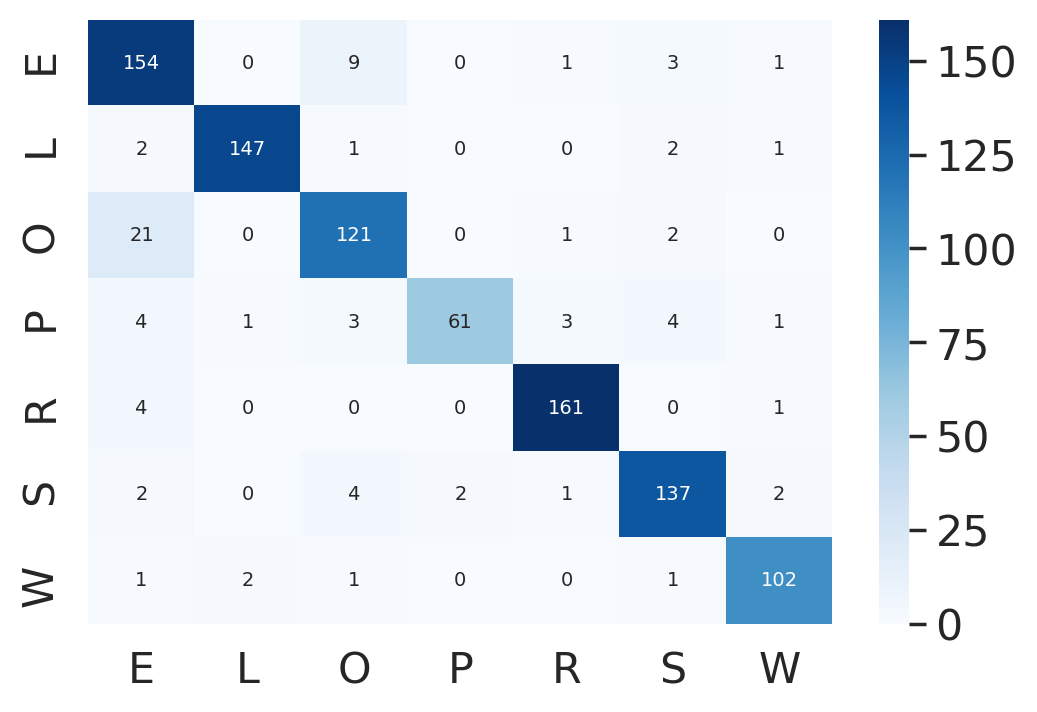

(0.9037267080745341, 0.2964194388616653)

In [137]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_matrix, index = [i for i in "ELOPRSW"],
                  columns = [i for i in "ELOPRSW"])

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate(model, test_loader, False, loss_fnc)

In [13]:
from torchsummary import summary
summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 178, 178]             280
       BatchNorm2d-2         [-1, 10, 178, 178]              20
         MaxPool2d-3           [-1, 10, 89, 89]               0
            Conv2d-4           [-1, 10, 87, 87]             910
       BatchNorm2d-5           [-1, 10, 87, 87]              20
         MaxPool2d-6           [-1, 10, 43, 43]               0
            Linear-7                  [-1, 400]       7,396,400
            Linear-8                    [-1, 7]           2,807
Total params: 7,400,437
Trainable params: 7,400,437
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 6.74
Params size (MB): 28.23
Estimated Total Size (MB): 35.34
----------------------------------------------------------------


In [11]:
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(model, (3, 180, 180), as_strings=False)

Net(
  7.4 M, 100.000% Params, 0.024 GMac, 100.000% MACs, 
  (pool): MaxPool2d(0.0 M, 0.000% Params, 0.0 GMac, 1.613% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_norm1): BatchNorm2d(0.0 M, 0.000% Params, 0.001 GMac, 2.604% MACs, 10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv_norm2): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.622% MACs, 10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv1): Conv2d(0.0 M, 0.004% Params, 0.009 GMac, 36.455% MACs, 3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(0.001 M, 0.012% Params, 0.007 GMac, 28.303% MACs, 10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(7.396 M, 99.945% Params, 0.007 GMac, 30.392% MACs, in_features=18490, out_features=400, bias=True)
  (fc2): Linear(0.003 M, 0.038% Params, 0.0 GMac, 0.012% MACs, in_features=400, out_features=7, bias=True)
)


In [12]:
print('model params: {} M'.format(int(params)/(10**6)))
print('model gflops: {} '.format(int(macs)*2/(10**9)))